## Import Necessary Modules

In [1]:
import glob
import cv2
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import resample
from scipy.optimize import curve_fit
import skimage.filters as filters
from collections import deque
from math import ceil
from IPython.display import Image
from moviepy.editor import VideoFileClip
%matplotlib inline
warped_size = np.array([1280, 720])
original_size =np.array([720, 1280])
OFFSET =0

## Image helper functions
* Use Table View to Display Group of Images when necessary for debugging.

In [2]:
def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None, plot_title ="None"):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')    
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=24)
                
    fig.tight_layout()
    fig.subplots_adjust(top=2.5)
    plt.show()

## Camera Calibration Helper Functions
* Get Chessboard Corners from Standard Images
* Calibrate Camera using differences in distances between expected and actual results
* Use Calibration data to Undistort Camera Images
<img src ="Camera_Calibration.png">
* Example of how Chessboard Corners are obtained before Calibration to Undstort and use it to have a Bird's Eye Perspective
<img src="Camera_calibration_Example.png">

In [3]:
# Get ChessBoard Corners 
def get_chessboard_corners(img_, x_, y_):
    """
    Get Chessboard Corners for Calibration of Camera Images
    :param img_: Image for Camera Calibration
    :param x_: X- Axis 
    :param y_: Y- Axes
    :return: Corners for Calibration
    """
    gray = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
    ret_, corners_ = cv2.findChessboardCorners(gray, (x_, y_), None)
    return ret_, corners_


# Calibrate Camera Function 
def camera_calibrate(images_, x_=9, y_=6, z_=3):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    """
    Calibrate the Camera Function
    :return: 
    :param images_: Image series for Camera Calibration
    :param x_: X axis points
    :param y_: Y Axis points
    :param z_: Z Axis points
    :return: Matrix and Distortion array for distortion correction
    """
    objp = np.zeros((x_ * y_, z_), np.float32)
    objp[:, :2] = np.mgrid[0:x_, 0:y_].T.reshape(-1, 2)
    objpoints = []
    imgpoints = []

    ### Read all Images in the folder One by One ####
    for idx, fname in enumerate(images_):
        img_ = cv2.imread(fname)
        ret, corners = get_chessboard_corners(img_, x_, y_)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                       (img_.shape[1], img_.shape[0]), None, None)
    return mtx, dist

# Undistort Images 
def undistort_image(mtx_, dist_, img_):
    """
    Undistort the image using distortion coefficients
    :param mtx_: Correction Matrix 
    :param dist_: Distortion Coefficient
    :param img_: Image that needs undistortion
    :return: Distortion Corrected Image
    """
    dst = cv2.undistort(img_, mtx_, dist_, None, mtx_)
    return dst


## Warping & Birds Eye View Generation
* Use Interactive Python to plot and understand what is the best set of source and destination points for each/ all the three videos of interest. After several days of experimentation we have finally arived at these numbers
* Use Get Perspective Transform for Matrix calculation that can be used to Warp The Image to Bird's eye view and Unwarp them back to the front view
<img src="Warp_Image_Final.png">

In [4]:
# Calculate Source and Destination points 
def calc_warp_points():
    """
    :return: Source and Destination pointts 
    """
    src = np.float32 ([
        [220, 651],
        [350, 577],
        [828, 577],
        [921, 651]
    ])

    dst = np.float32 ([
            [220, 651],
            [220, 577],
            [921, 577],
            [921, 651]
        ])
    return src, dst


# Calculate Transform 
def calc_transform(src_, dst_):
    """
    Calculate Perspective and Inverse Perspective Transform Matrices 
    :param src_: Source points
    :param dst_: Destination Points
    :return: Perspective Matrix and Inverse Perspective Transform Matrix
    """
    M_ = cv2.getPerspectiveTransform(src_, dst_)
    Minv_ = cv2.getPerspectiveTransform(dst_, src_)
    return M_, Minv_


# Get perspective transform 
def perspective_transform(M_, img_):
    """

    :param M_: Perspective Matrix 
    :param img_ : Input Image
    :return: Transformed Image 
    """
    img_size = (img_.shape[1],img_.shape[0])
    transformed = cv2.warpPerspective(
        img_,
        M_, img_size,
        flags=cv2.WARP_FILL_OUTLIERS + cv2.INTER_CUBIC)
    return transformed


# Inverse Perspective Transform 
def inv_perspective_transform(Minv_, img_):
    """

    :param M_: Inverse Perspective Transform Matrix
    :param img_: Input Image
    :return: Transformed Image
    """
    img_size = (img_.shape[1], img_.shape[0])
    transformed = cv2.warpPerspective(
        img_,
        Minv_, img_size,
        flags=cv2.WARP_FILL_OUTLIERS + cv2.INTER_CUBIC)
    return transformed


## Image Thresholding Helper Functions
<img src= "Image_Thresholding_Final.png">
### Morphological Channel :
* Use HLS S- Channel and Gray Channel to create Morphological Channel
* Threshold the Morph Channel to get the most dominant features 
* Determine Levels of Thresholds using Mean and Standard Deviations 

### Environment Mask :
* Use B-Channel from the LAB Colorspace to choose Yellow and Shades of Yellow 
* Use HLS Channel to filter out everything not in range of threshold. "


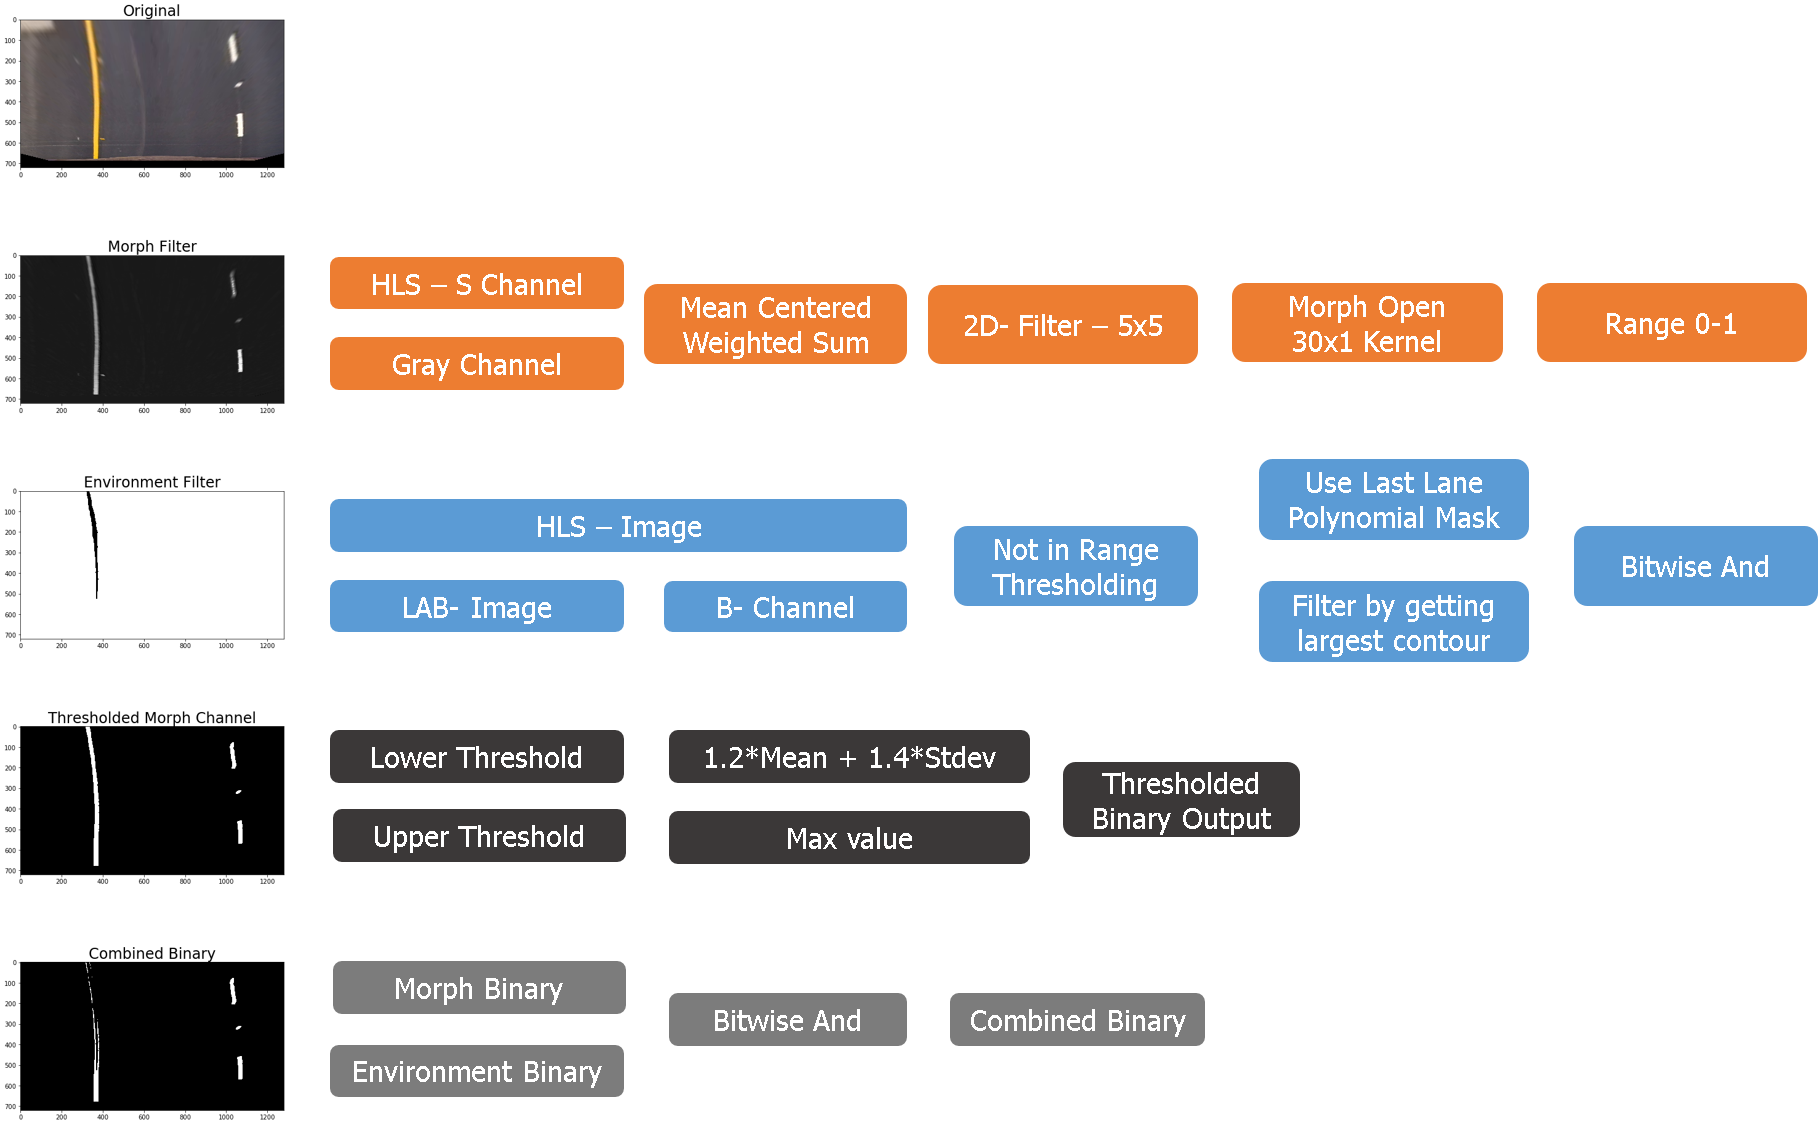

In [5]:
# Morphology filter
def morphology_filter(img_):
    """

    :param img_: Input Image
    :return: Morphologically Filtered Image
    """
    gray = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
    hls_s = cv2.cvtColor(img_, cv2.COLOR_RGB2HLS)[:, :, 2]
    src = 0.6*hls_s + 0.4*gray
    src = np.array(src-np.min(src)/(np.max(src)-np.min(src))).astype('float32')-0.5
    blurf = np.zeros((1, 5))
    blurf.fill(1)
    src = cv2.filter2D(src, cv2.CV_32F, blurf)
    f = np.zeros((1, 30))
    f.fill(1)
    l = cv2.morphologyEx(src, cv2.MORPH_OPEN, f)
    filtered = src - l
    return filtered


# Image Threshold
def img_threshold(img_):
    """

    :param img_: Input Image
    :return: Thresholded Image
    """
    global fCount
    global last_mask

    # Use HLS, LAB Channels for Thresholding #
    img_hls = cv2.cvtColor(img_, cv2.COLOR_RGB2HLS)
    img_hls = cv2.medianBlur(img_hls, 5)
    b_channel = cv2.cvtColor(img_, cv2.COLOR_RGB2LAB)[:, :, 2]
    b_channel = cv2.medianBlur(b_channel, 5)

    # Filter out Greenery & Soil from environment 
    environment = np.logical_not((b_channel > 145) & (b_channel<200) & cv2.inRange(img_hls, (0, 0, 50), (35, 192, 255))).astype(np.uint8) & (img_hls[:, :, 1] < 245)

    #Deal with shadows and bright spots on the road #
    # The shapes can be elliptical or rectangular #
    big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    environment = cv2.morphologyEx(environment, cv2.MORPH_OPEN, small_kernel)
    environment_mask = cv2.dilate(environment, big_kernel)
    
    # Use Lane from Last mask to filter ROI
    img_mask = cv2.bitwise_and(last_mask, environment_mask)


    # Morphology Channel Thresholding 
    morph_channel = morphology_filter(img_)
    morph_thresh_lower = 1.2*np.mean(morph_channel) + 1.3*np.std(morph_channel)
    morph_thresh_upper = np.max(morph_channel)
    morph_binary = np.zeros_like(morph_channel)
    morph_binary[(morph_channel >= morph_thresh_lower) &
                 (morph_channel <= morph_thresh_upper)] = 1

    # Erosion Kernel to clear out small granular noises
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    morph_binary = cv2.morphologyEx(morph_binary.astype(np.uint8), cv2.MORPH_ERODE, erosion_kernel)
    morph_binary = cv2.morphologyEx(morph_binary, cv2.MORPH_OPEN, small_kernel)
    combined_binary = cv2.bitwise_and(morph_binary.astype(np.uint8), img_mask.astype(np.uint8))


    return combined_binary.astype(np.uint8)


### Polynomial & Mathematical Helper Functions

In [6]:
# Extract Pixels from Image 
def extract_pixels(img_):
    """
    Extract all Non Zero Pixels and return X, Y Coordinates
    :param img_: Image from which Non Zero Pixels have to be extracted
    :return: X & Y Coordinates
    """
    non_zero_pixels = np.argwhere(0 < img_)
    x = non_zero_pixels.T[0].astype(np.float32)
    y = non_zero_pixels.T[1].astype(np.float32)
    return x, y

# Get Intercepts 
def get_intercepts(fit, y):
    """
    Get x intercepts for given y value
    :return: 
    :param fit: The polynomial fit
    :param y: Y Coordinates
    :return: X Coordinates
    """
    x = fit[0] * (y * y) + fit[1] * y + fit[2]
    return x

# Draw Polygon based on X, and Y points for Left and Right Lanes on Image
def draw_polygon(left_x, right_x, left_y, right_y, img_):
    """
    Get Left_x, Right_x, Left_y, Right_y, Image , return Image with Polygon
    :return: 
    :param left_x: 
    :param right_x: 
    :param left_y: 
    :param right_y: 
    :param img_: 
    :return: 
    """
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_x, left_y])))])
    pts_right = np.array([np.transpose(np.vstack([right_x, right_y]))])
    pts = np.hstack((pts_left, pts_right))
    img_ = cv2.polylines(img_, np.int_([pts]), isClosed=False, color=(0, 0, 255), thickness=25)
    img_ = cv2.fillPoly(img_, np.int_(pts), (34, 255, 34))
    return img_


## Masking & Searching
There are two kinds of masking adn search techniques to look for lanes 
### Blind Search 
* Scan through entire image for pixels and mask out invalid pixels
* Left and Right masks are computed sequentially.
* Left is computed first followed by Right which is computed after Image is masked with the left mask. 
<img src="BlindSearch.png">

Left Blind Search Example                 | Right Blind Search Example
-                                         | -
![alt](Mask_Computation_Example_Left.png) | ![alt](Mask_Computation_Example_Right.png)

### Combined Mask
* Numerically / Logically add masks to get overall mask. 
<img src="Left_And_Right_Mask.png">

### Polyomial Search  
* Based on previous detected lane and interval specified . 
<img src="PolynomialSearch.png">



In [16]:
def coordinates_to_imgpts(x, y):
    """
    Convert parameters from X,Y plane to Image Plane Points
    :param x: 
    :param y: 
    :return pts:
    """
    pts = np.array([np.flipud(np.transpose(np.vstack([x, y])))])
    return pts

def draw_polylines(input_img, pts, window_size):
    """
    Draw Polylines for points with given thickness specified by Window Size
    :param input_img: 
    :param pts: 
    :param window_size: 
    :return: Image with Poly Lines 
    """
    return cv2.polylines(input_img, np.int_([pts]), isClosed=False, color=(255, 255, 255),
                         thickness=2 * window_size)


def smoothen_masks(fit, img_, window_size):
    """
     # Use polyfit from the mask points for smoothening them 
    :param fit: 
    :param img_: 
    :param window_size: 
    :return: 
    """
    img_size = img_.shape
    mask_poly = np.zeros_like(img_)
    # Get top to Bottom for refactoring #
    mask_y = np.linspace(0, img_size[0] - 1, img_size[0])
    mask_x = get_intercepts(fit, mask_y)

    # Smoothen the mask #
    pts = coordinates_to_imgpts(mask_x, mask_y)
    mask_poly_smooth = draw_polylines(mask_poly, pts, window_size)
    return mask_poly_smooth

# Use when Lane is Found and Polynomial fit can be used with a Tolerance window to search for lanes
def limited_search(img_, window_size, flag='L'):
    """
    Polynomial search based on previous fit
    :param img_: 
    :param window_size: 
    :param flag: 
    :return: 
    """
    # Initialize Mask with Same Size as Image #
    mask_poly = np.zeros_like(img_)
    # Get previous Coefficients #
    fit = get_last_fit(flag=flag)
    if fit is not None:
        mask_poly_smooth = smoothen_masks(fit, img_, window_size)
        return mask_poly_smooth.astype(np.uint8)
    else:
        return mask_poly
    
# Sliding Window Blind Search to generate a mask for Polynomial fit generation
def blind_search(img_, window_size = 30):
    img_size = img_.shape
    n_segments = 16
    step = img_size[0]//n_segments
    mask_L_poly = np.zeros_like(img_)
    mask_R_poly = np.zeros_like(img_)
    n_steps = 4
    window_start = img_size[1]//2 - 9 * window_size
    window_end = window_start + 6*window_size
    sm = np.sum(img_[img_size[0]-4*step:img_size[0], window_start:window_end], axis=0)
    sm = np.convolve(sm, np.ones((window_size,))/window_size, mode='same')
    argmax = window_start + np.argmax(sm)
    shift = 0
    plt.figure(figsize=(10,6))
    i =0
    for last in range(img_size[0], 0, -step):
        first_line = max(0, last - n_steps*step)
        sm = np.sum(img_[first_line:last, :], axis=0)
        sm = np.convolve(sm, np.ones((window_size,))/window_size, mode='same')
        window_start = min(max(argmax + int(shift)-window_size//2, 0), img_size[1]-1)
        window_end = min(max(argmax + int(shift) + window_size//2, 0+1), img_size[1])
        new_argmax = window_start + np.argmax(sm[window_start:window_end])
        new_max = np.max(sm[window_start:window_end])
        if new_max <= 2:
            new_argmax = argmax + int(shift)
            shift = shift/2
        if last != img_size[0]:
            shift = shift*0.25 + 0.75*(new_argmax - argmax)
        argmax = new_argmax
        mask_L_poly = cv2.rectangle(mask_L_poly, (argmax-window_size//2, last-step), (argmax+window_size//2, last), 1, thickness=window_size)
        
    not_left = np.logical_not(mask_L_poly).astype(np.uint8)
    filtered_img = cv2.bitwise_and(img_,not_left)
    
    window_start = img_size[1]//2 + 6 * window_size
    window_end = window_start + 6*window_size
    sm = np.sum(filtered_img[img_size[0]-4*step:img_size[0], window_start:window_end], axis=0)
    sm = np.convolve(sm, np.ones((window_size,))/window_size, mode='same')
    argmax = window_start + np.argmax(sm)
    shift = 0
    for last in range(img_size[0], 0, -step):
        first_line = max(0, last - n_steps*step)
        sm = np.sum(filtered_img[first_line:last, :], axis=0)
        sm = np.convolve(sm, np.ones((window_size,))/window_size, mode='same')
        window_start = min(max(argmax + int(shift)-window_size//2, 0), img_size[1]-1)
        window_end = min(max(argmax + int(shift) + window_size//2, 0+1), img_size[1])
        new_argmax = window_start + np.argmax(sm[window_start:window_end])
        new_max = np.max(sm[window_start:window_end])
        if new_max <= 2:
            new_argmax = argmax + int(shift)
            shift = shift/2
        if last != img_size[0]:
            shift = shift*0.25 + 0.75*(new_argmax - argmax)
        argmax = new_argmax
        mask_R_poly = cv2.rectangle(mask_R_poly, (argmax-window_size//2, last-step), (argmax+window_size//2, last), 1, thickness=window_size)

    return mask_L_poly, mask_R_poly

## Queue Helper Functions
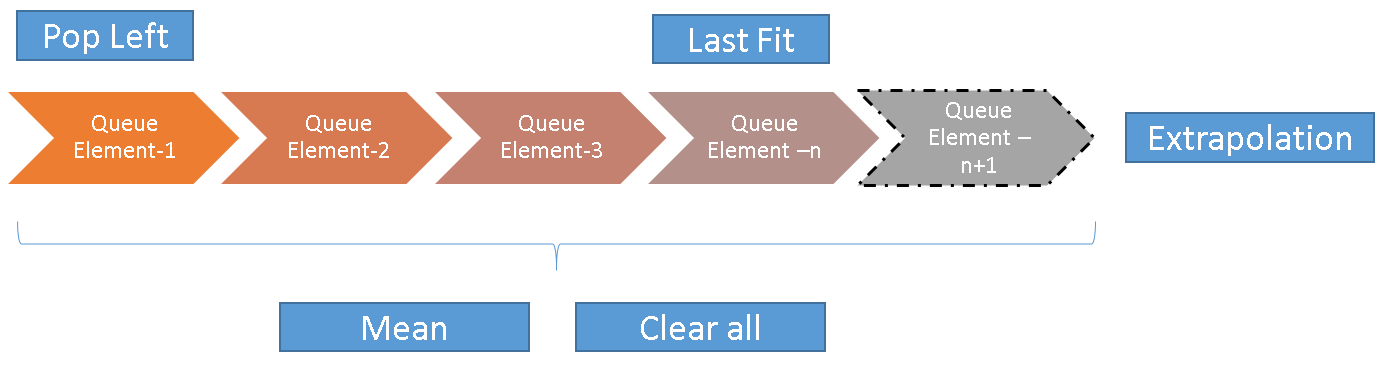
____________________________________
* Queues are extremely useful tools for First In First Out queues. 
* The size of the queues when they are really large can help stabilize values very well in case of noisy conditions
* The size of the queues can also slow down the speed at which the lanes 

### Fit Functions:
____________________
* **Mean Fit** : Get average fit over n-samples specified
* **Predicted Fit**: Extrapolate fit values if next sample is valid
* **Last Fit**: Last valid fit in the queue

### Curvature Functions:
___________________________
* **Mean Curvature** : Get average curvature over n-samples specified
* **Predicted Curvature**: Extrapolate curvature values if next sample is valid
* **Last Curvature**: Last valid curvature in the queue

### Other Functions:
____
* **Clear Queues**: Clear the queues completely
* **Pop Left**: Pop the left most value in the queues 

In [17]:
def get_mean_fit(flag='L'):
    """
    Get the mean value of fit "Left" and "Right" based on flag
    :param flag: 
    :return: 
    """
    if flag == 'L':
        return np.mean(np.vstack(l_coeff_queue), axis =0) if len(l_coeff_queue)>1 else l_coeff_queue[-1]
    else:
        return np.mean(np.vstack(r_coeff_queue), axis =0) if len(r_coeff_queue)>1 else r_coeff_queue[-1]

def get_predicted_fit(flag ='L'):
    if flag =='L':
        if len(l_coeff_queue)>1:
            avg_diff_L = np.mean(np.vstack(np.diff(np.vstack(l_coeff_queue), axis=0)), axis =0)
            return np.add(get_mean_fit(flag="L"),avg_diff_L)
        else:
            return l_coeff_queue[-1]
    else:
        if len(r_coeff_queue)>1:
            avg_diff_R = np.mean(np.vstack(np.diff(np.vstack(r_coeff_queue), axis =0)), axis =0)
            return np.add(get_mean_fit(flag="R"),avg_diff_R)
        else:
            return r_coeff_queue[-1]

def get_last_fit(flag='L'):
    """
    Gets the Last Fit depending on the flag 
    :param flag: 
    :return: 
    """
    if flag == 'L':
        return l_coeff_queue[-1]
    else:
        return r_coeff_queue[-1]

def get_mean_curvature(flag='L'):
    if flag =='L':
        return np.mean(l_offset_queue), np.mean(l_curvature_queue)
    else:
        return np.mean(r_offset_queue), np.mean(r_curvature_queue)
                                                
def get_last_curvature(flag='L'):   
    if flag =='L':
        return l_offset_queue[-1], l_curvature_queue[-1]
    else:
        return r_offset_queue[-1], r_curvature_queue[-1]

def return_queue_len(flag='L'):
    if flag =='L':
        return len(l_coeff_queue)
    else:
        return len(r_coeff_queue)

def clear_queues():
    l_coeff_queue.clear()
    r_coeff_queue.clear()
    l_offset_queue.clear()
    l_curvature_queue.clear()
    r_offset_queue.clear()
    r_curvature_queue.clear()
    detected_count =0
    overall_offset =0
    
def pop_queues_left():
    l_coeff_queue.popleft()
    r_coeff_queue.popleft()
    l_curvature_queue.popleft()
    r_offset_queue.popleft()
    r_curvature_queue.popleft()

def append_linecoeffs(fit, flag='L'):
    if flag=='L':
        # left line Coefficients
        l_coeff_queue.append(fit)
    else:
        # Right Line Coefficients
        r_coeff_queue.append(fit)
    return None

def append_curvature(offset, curvature, flag='L'):
    if flag =='L':
        l_curvature_queue.append(curvature)
        l_offset_queue.append(offset)
    else:
        r_curvature_queue.append(curvature)
        r_offset_queue.append(offset)     
    return None

def append_overall_offset(left_offset, right_offset):
    global overall_offset
    overall_offset = 0
    overall_offset = left_offset + right_offset
    overall_offset = overall_offset / 2.
    overall_offset = center_position - overall_offset
    return None

In [9]:
def calc_curvature(fit, img_):
    img_size= img_.shape
    y_eval = img_size[0]
    if fit is not None:
        a = fit[0] * xm_per_pix / ym_per_pix**2
        b = fit[1] * xm_per_pix / ym_per_pix
        c = fit[2] * xm_per_pix
        y = y_eval * ym_per_pix
    else:
        return None, None
    
    rad_curvature = pow(1 + (2*a*y + b)**2, 1.5) / math.fabs (2*a)
    offset = calc_offset(fit,y_eval)
    
    return offset, rad_curvature

def calc_offset(fit, y_eval):
    
    a = fit[0] * xm_per_pix / ym_per_pix**2
    b = fit[1] * xm_per_pix / ym_per_pix
    c = fit[2] * xm_per_pix
    y = y_eval * ym_per_pix
    return (a*y*y + b*y + c)

def check_and_fit(x, y, flag='L', threshold=1000):
    """
    Verify if number of pixels are satisfactory for a confident fit and then fit 
    :param x: 
    :param y: 
    :param flag: 
    :param threshold: 
    :return:
    """
    
    confidence_index = len(x)
    if IsLaneFound is False:
        threshold =500
    if confidence_index < threshold:
        fit = None
        foundFlag = False
    else:
        fit, cov = curve_fit(lambda x, a, b, c:a*x*x+b*x + c , x, y)
        foundFlag = True
    return fit, foundFlag, confidence_index


def mask_and_fit(mask, binary_warped, flag):
    """
    Mask the Images and then return the equation of the lane lines
    :return: 
    :param mask: 
    :param binary_warped: 
    :param flag: 
    :return: 
    """
    img = cv2.bitwise_and(binary_warped, binary_warped, mask=mask)
    x, y = extract_pixels(img)
    fit, foundFlag, confidence_index = check_and_fit(x, y, flag)
    return fit, foundFlag, confidence_index


In [10]:
def curvature_sanity(left_curvature, left_offset, right_curvature, right_offset):
    """
    Use The current values of Curvature and Offset from Left and Right Lanes 
    to decide if Lanes are sane 
    :param left_curvature: 
    :param left_offset: 
    :param right_curvature: 
    :param right_offset: 
    :return: 
    """
    if return_queue_len(flag='L') >= 1 and return_queue_len(flag='R') >= 1:
        offset = center_position - (left_offset + right_offset) / 2.
        offset_measure = np.abs(overall_offset - offset)
        return True if offset_measure < 0.2 else False
    else:
        return True



def update_lanewidth(left_fit, right_fit, img_):
    """
    Use the left and right fit 
    :return: 
    :param left_fit: 
    :param right_fit: 
    :param img_: 
    :return: 
    """
    img_size = img_.shape
    y_eval = np.linspace(0, img_size[0], 20)
    left_x = get_intercepts(left_fit, y_eval)
    right_x = get_intercepts(right_fit, y_eval)
    return np.clip(right_x - left_x, 400, 800)


def lanewidth_sanity(left_fit, right_fit, img_):
    """
    
    :return: 
    :param left_fit: 
    :param right_fit: 
    :param img_: 
    :return: 
    """
    global lane_width
    img_size = img_.shape
    ploty = np.linspace(0, img_size[0], 20)
    left_distances = np.vstack(calc_offset(left_fit, ploty)).T
    right_distances = np.vstack(calc_offset(right_fit, ploty)).T
    distances = right_distances - left_distances
    lanewidth = lane_width * xm_per_pix
    min_lanewidth = np.mean(lanewidth) - 2.5 * np.std(lanewidth)
    max_lanewidth = np.mean(lanewidth) + 2.5 * np.std(lanewidth)
    passes = np.sum((min_lanewidth <= distances) & (distances <= max_lanewidth)) / len(distances[0])
    return True if passes >= 0.95 else False


def lanewidth_rationalize(left_fit, confidence_index_l, right_fit, confidence_index_r, img_):
    """

    :param left_fit: 
    :param confidence_index_l: 
    :param right_fit: 
    :param confidence_index_r: 
    :param img_: 
    :return: 
    """
    img_size = img_.shape
    y = np.linspace(0, img_size[0], 20)
    if confidence_index_l > 2. * confidence_index_r or (left_fit is not None and right_fit is None):
        x = get_intercepts(left_fit, y) + lane_width
        right_fit, cov = curve_fit(lambda x, a, b, c: a * x * x + b * x + c, y, x)
    elif confidence_index_r > 2. * confidence_index_l or (left_fit is None and right_fit is not None):
        x = get_intercepts(right_fit, y) - lane_width
        left_fit, cov = curve_fit(lambda x, a, b, c: a * x * x + b * x + c, y, x)

    return left_fit, right_fit


## Video Pipeline
### Complete Process Involves
* **Calibrate** - Use Camera Calibrate Function to get Distortion Matrix
* **Undistort** -  Use Computed Distortion Matrix to correct for Distortion
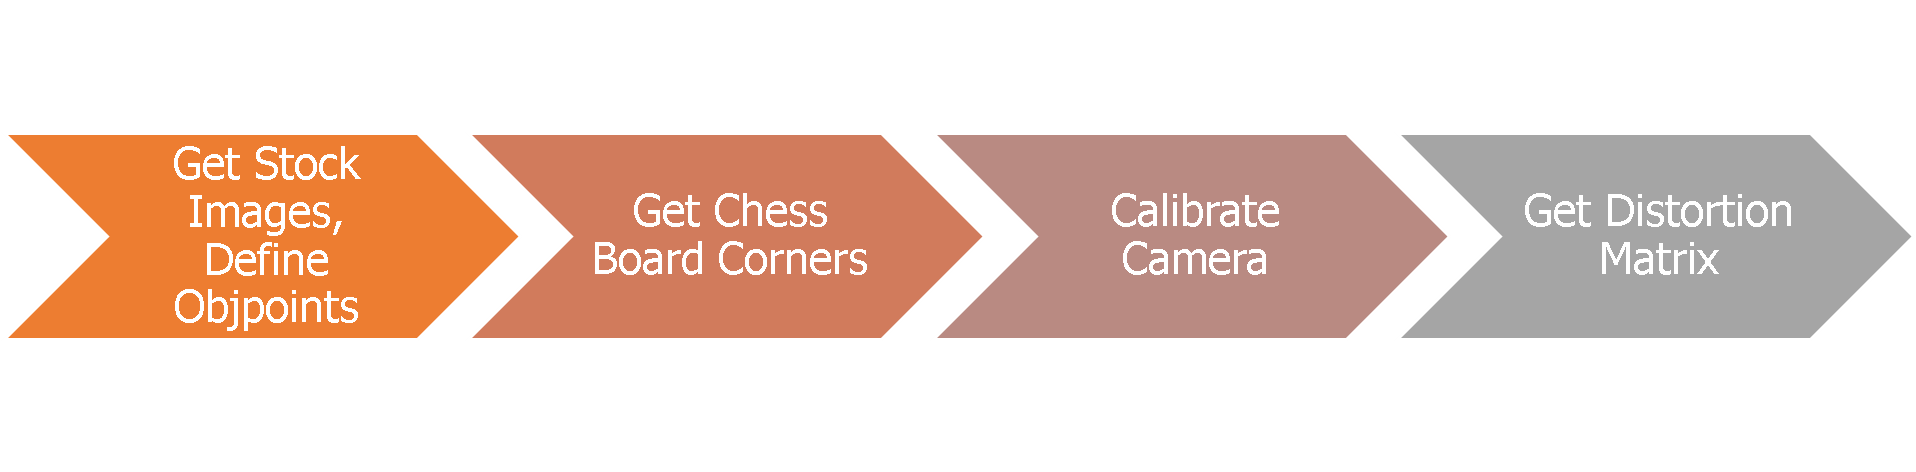
* **Warp** - Use Warping Function to get Bird's eye view 
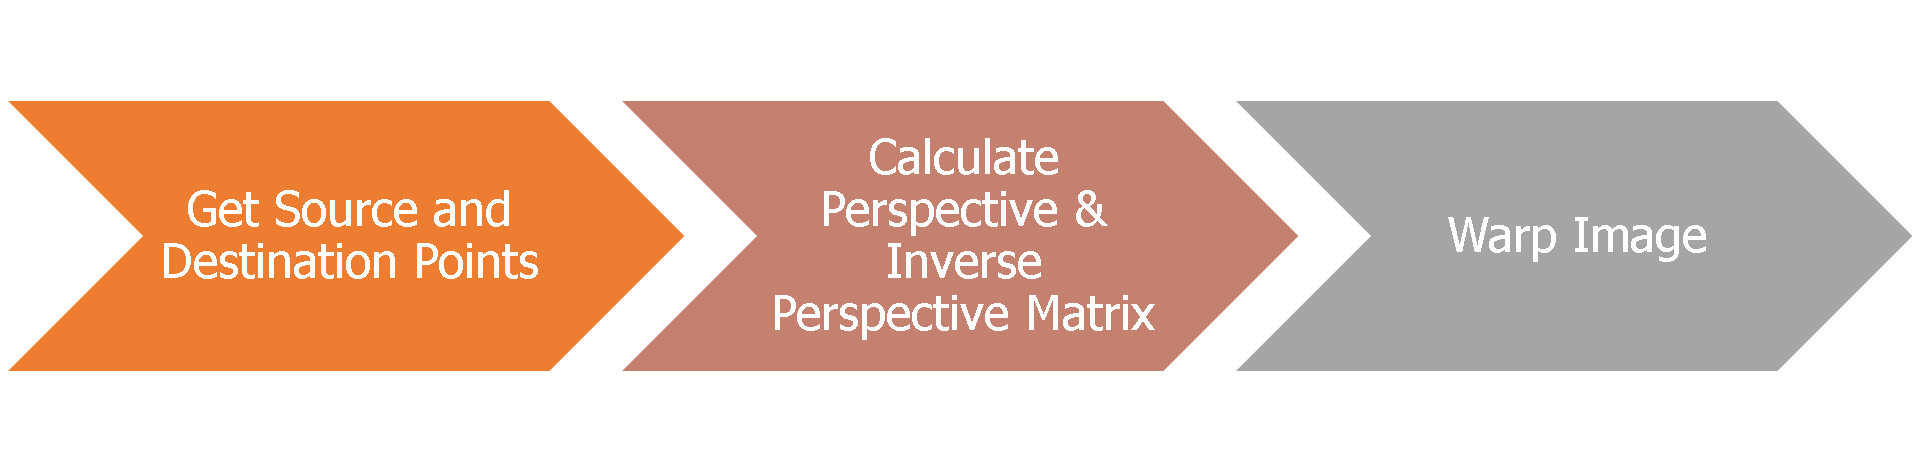
* **Threshold** - Use a combination of static , dynamic thresholding with morph transformations & colorspaces to get thresholded image
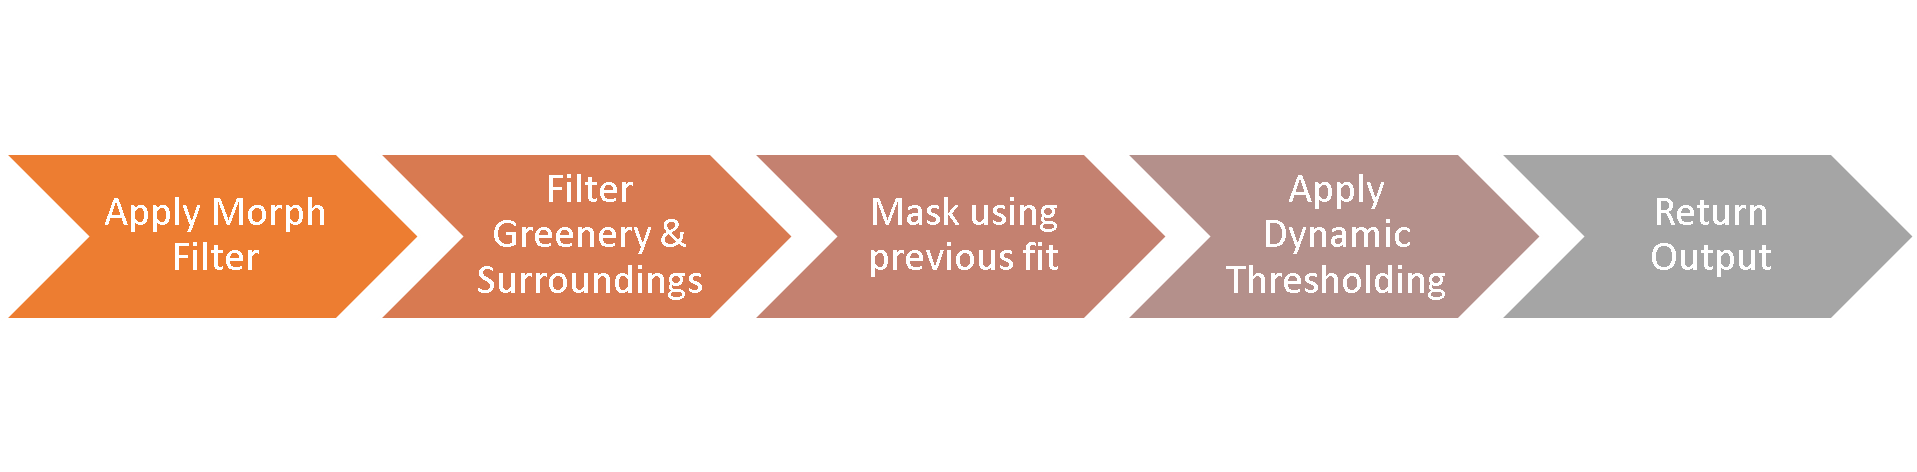

* **Extract Pixel Information** - Use Quantity based thresholding to and extract non-zero pixels
* **Validate and Fit** - Use Curvature and LaneWidth Sanity mechanisms to check the validity of the two fits obtained for a given frame and decide on whether to use the current fit or use an extrapolated average of the previous fits 
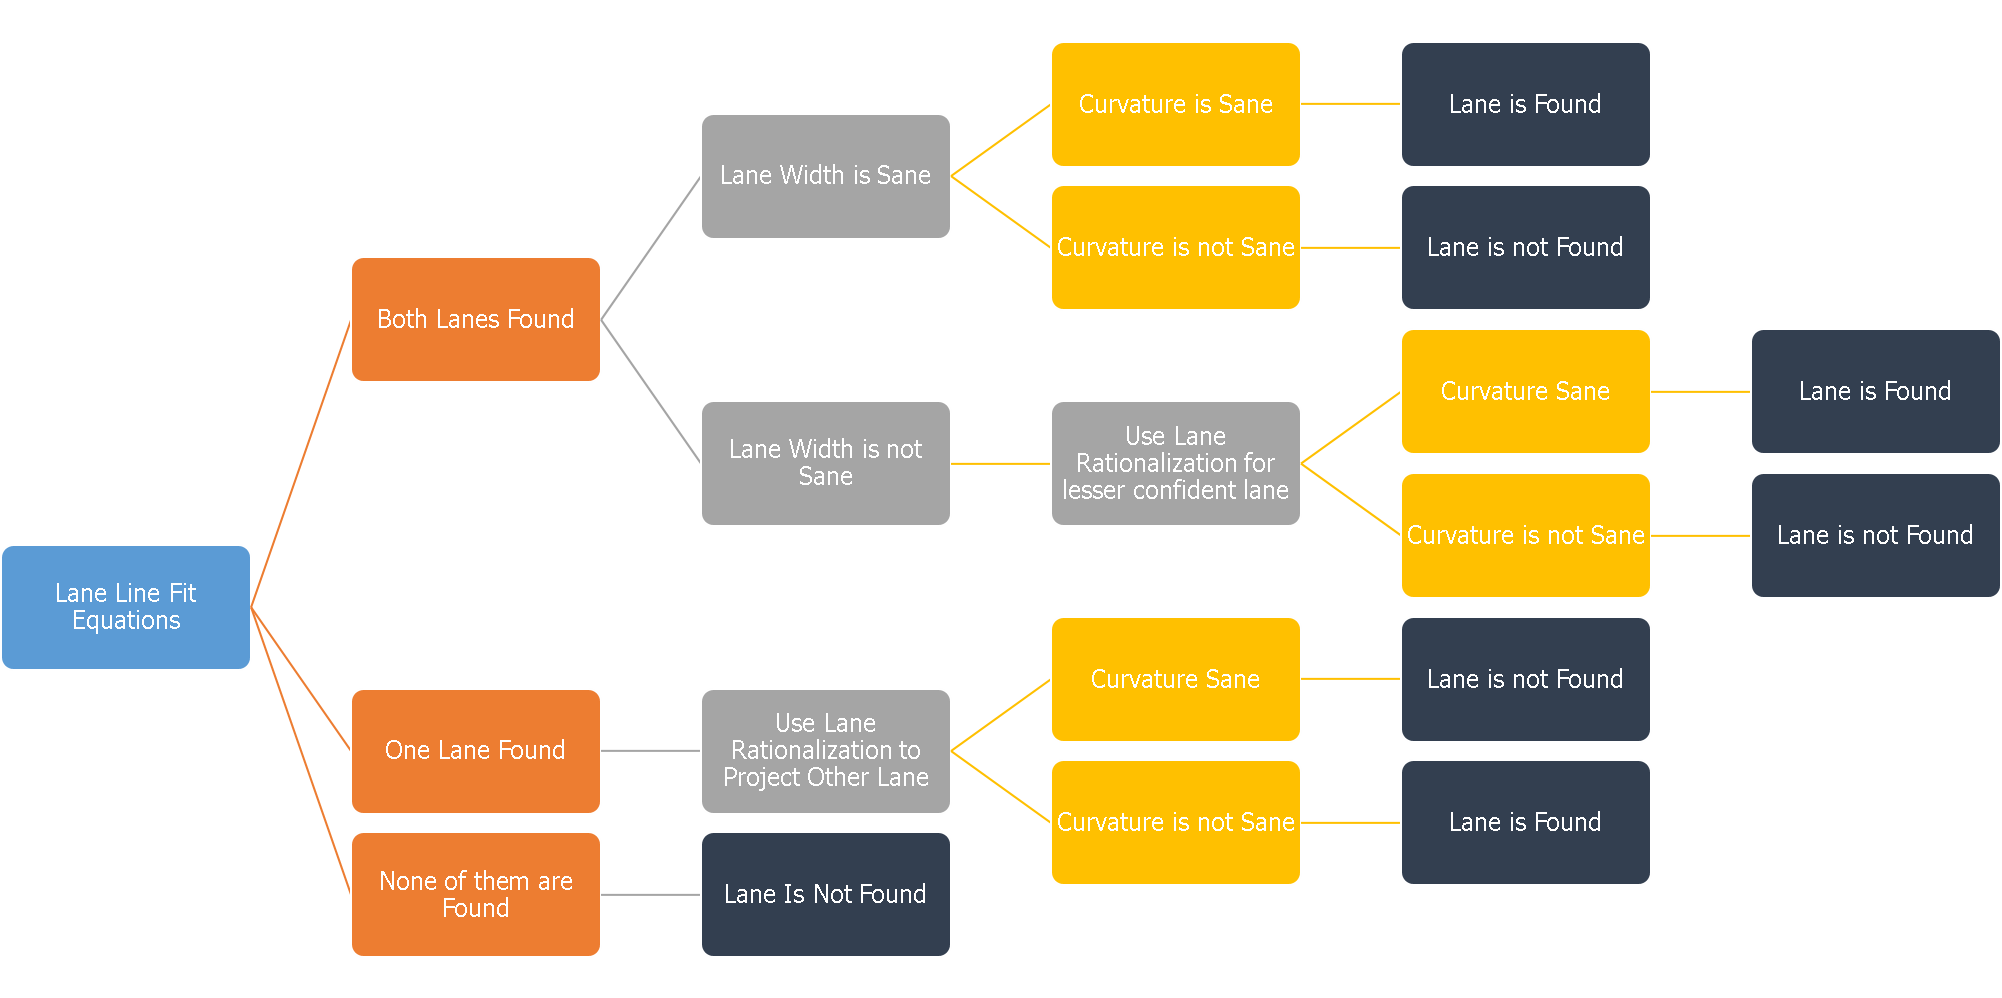
* **Project Fit on to Image ** - Convert the x, y plane points and fit to image plane points and draw polygon on the image.
* **Unwarp** - Use Inverse Perspective Transform to unwarp the image. 
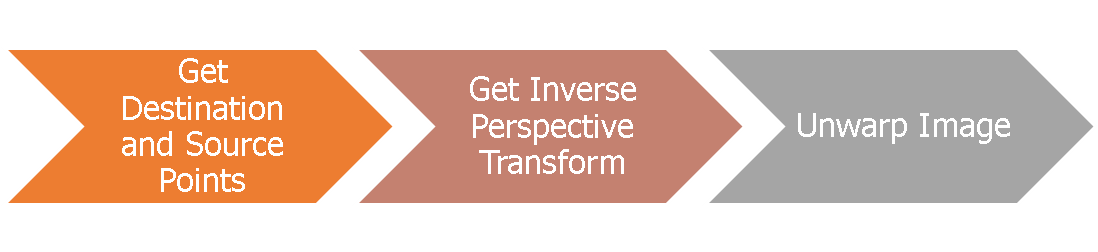
* **Output** - Return the processed frame . 
<img src="Complete_process.png">

### Example Images from Each of the video 
#### Harder Challenge
<img src="Harder_Challenge_Video_Pipeline.png">
#### Challenge Video 
<img src="Challenge_ Video_pipeline.png">
#### Project Video
<img src="Project_Video_Pipeline.png">

In [14]:
# Master Function that processes video image by image
def process_video(img):
    """

    :param img: 
    :return: Processed Image that is written with appropriate polygon
    """
    global isPerspectiveCompute
    global m
    global minv
    global IsLaneFound
    global fCount
    global last_mask
    global patience
    global lane_width
    global disp_left 
    global disp_right
    global lane_width
    global xm_per_pix

    # Initialize Variables
    l_found_flag = False
    r_found_flag = False
    confidence_index_l = 0
    confidence_index_r = 0
    img_size = img.shape
    IsLaneWidthSane = False
    IsCuvatureSane = False

    # Perform Camera Calibration and  get Distortion Coefficients #
    undistorted_img = undistort_image(mtx, dist, img)

    # Calculate Bird' Eye Transform #
    if not isPerspectiveCompute:
        src_, dst_ = calc_warp_points()
        bin_ex = draw_polylines(undistorted_img, src_, 5)
        m, minv = calc_transform(src_, dst_)
        isPerspectiveCompute = True

    # Get Bird's Eye View #
    warped = perspective_transform(m, undistorted_img)
    binary_warped = img_threshold(warped)

    # Lane Search
    # Polynomial Search if Lane is Found
    if IsLaneFound:
        
        #Left Mask and Fit
        mask_l_poly = limited_search(binary_warped, int(35), flag='L')
        left_fit, l_found_flag, confidence_index_l = mask_and_fit(mask_l_poly, binary_warped, 'L')
        
        # Right Mask and Fit 
        mask_r_poly = limited_search(binary_warped, int(35), flag='R')
        right_fit, r_found_flag, confidence_index_r = mask_and_fit(mask_r_poly, binary_warped, 'R')
        
    # Try Blind Search if Lane is Not Found
    else:
        mask_l_poly, mask_r_poly = blind_search(binary_warped, int(35))
        #Mask and Fit Left and Right Lanes
        left_fit, l_found_flag, confidence_index_l = mask_and_fit(mask_l_poly, binary_warped, 'L')
        right_fit, r_found_flag, confidence_index_r = mask_and_fit(mask_r_poly, binary_warped, 'R')

    # Check if Lane is found after searching , verify if the detected lanes are sane

    if left_fit is not None or right_fit is not None:
        # Check sanity in combination 
        if left_fit is not None and right_fit is not None:
            IsLaneWidthSane = lanewidth_sanity(left_fit, right_fit, binary_warped)
        if not IsLaneWidthSane:
            left_fit, right_fit = lanewidth_rationalize(left_fit, confidence_index_l, 
                                                        right_fit, confidence_index_r, binary_warped)
 
        # Calculate Offset and Curvature
        left_offset, left_curvature = calc_curvature(left_fit, binary_warped)
        right_offset,right_curvature = calc_curvature(right_fit, binary_warped)
        IsCurvatureSane = curvature_sanity(left_curvature, left_offset, right_curvature, right_offset)
        
        if IsCurvatureSane is True:
            IsLaneFound = True
            patience = 0 
            # Append Left & Right Lane Coefficients, Curvature, offset
            append_linecoeffs(left_fit, flag='L')
            append_curvature(left_offset, left_curvature, flag='L')
            append_linecoeffs(right_fit, flag='R')
            append_curvature(right_offset, right_curvature, flag='R')
            append_overall_offset(left_offset, right_offset)
            if IsLaneWidthSane is True :
                xm_per_pix = 3.7/ np.median(lane_width)
                lane_width = update_lanewidth(left_fit, right_fit, binary_warped)
        else:
            IsLaneFound = False
            patience = patience + 1
            if ((return_queue_len(flag='L') >1 and return_queue_len(flag='R') > 1)): 
                pop_queues_left()
                
                # Left & Right Fit
                left_fit  = get_predicted_fit(flag ='L')
                right_fit  = get_predicted_fit(flag ='R')

                #Left and Right Curvature Offset
                left_offset, left_curvature = calc_curvature(left_fit, binary_warped)
                right_offset, right_curvature =calc_curvature(right_fit, binary_warped)

                #Append Coefficients , Curvature
                append_linecoeffs(left_fit , flag='L')
                append_linecoeffs(right_fit, flag='R')
                append_curvature(left_offset, left_curvature, flag='L')
                append_curvature(right_offset, right_curvature, flag='R')

                #Overall 
                append_overall_offset(left_offset, right_offset)

    # If queue length is greater than 1
    if ((return_queue_len(flag='L') >= 1 and return_queue_len(flag='R') >= 1)):         
    
        # Get the mean offset
        left_fit = get_mean_fit(flag='L')
        right_fit = get_mean_fit(flag='R')

        # Left Mean offset and Right Mean offset 
        left_mean_offset, left_mean_curvature = get_mean_curvature(flag='L')
        right_mean_offset, right_mean_curvature = get_mean_curvature(flag='R')

        # Recompute masks for masking next frame
        mask_l_poly = smoothen_masks(get_last_fit(flag='L'), binary_warped, 50)
        mask_r_poly = smoothen_masks(get_last_fit(flag='R'), binary_warped, 50)
        last_mask = cv2.bitwise_or(mask_l_poly, mask_r_poly)

        if not IsLaneFound:
            last_mask = np.ones_like(binary_warped)
            
        # Refactor, draw a polygon and unwarp the image
        ploty = np.linspace(0, img_size[1] - 1, img_size[1])
        leftx = get_intercepts(left_fit, ploty)
        rightx = get_intercepts(right_fit, ploty)
        warped_out = draw_polygon(leftx, rightx, ploty, ploty, warped)
        unwarped_out = inv_perspective_transform(minv, warped_out)
        output = cv2.addWeighted(img, 0.5, unwarped_out, 0.5, 0)
        
        if fCount%5==0:
            disp_left = ceil(left_mean_curvature)
            disp_right = ceil(right_mean_curvature)
            
        font = cv2.FONT_HERSHEY_SIMPLEX
        str1 = str("Left Mean Curvature : ") + str(disp_left)
        str2 = str("Right Mean Curvature : ") + str(disp_right)
        cv2.putText(output, str1, (120, 630), font, 1, (0, 0, 255), 2,
                    cv2.LINE_AA)
        cv2.putText(output, str2, (700, 630), font, 1, (0, 0, 255), 2,
                    cv2.LINE_AA)
        
    # If none of it is available 
    else:
        warped_out = img
        unwarped_out = img
        output = img
        font = cv2.FONT_HERSHEY_SIMPLEX
        str1 = str(' Lost Lane Tracking')
        cv2.putText(output, str1, (430, 630), font, 1, (0, 0, 255), 2,
                    cv2.LINE_AA)
        
    fCount = fCount + 1    
    return output

### Global Variables Initialize & Invoke area

In [15]:
#Define Length of Queue 
queue_len= 10
fCount = 0

# Coefficients Queue 
l_coeff_queue = deque(maxlen=queue_len)
r_coeff_queue = deque(maxlen=queue_len)


# Curvature & Offset Queue 
l_curvature_queue = deque(maxlen=queue_len)
r_curvature_queue = deque(maxlen=queue_len)
l_offset_queue = deque(maxlen=queue_len)
r_offset_queue = deque(maxlen=queue_len)

# Last Mask 
last_mask = np.ones(original_size).astype(np.uint8)
pix_width = 725
ym_per_pix = 30./original_size[0] #meters per y pixel
lane_width = np.random.normal(pix_width,250, 20)
xm_per_pix = 3.7/pix_width #meters per x pixel
center_position = original_size[1] * xm_per_pix / 2.

overall_offset = 0

# Flags for Event based triggering of actions 
IsLaneFound=False
isPerspectiveCompute = False
patience = 0

# Display Curvature
disp_left = 0
disp_right =0

# Camera Calibration Routine 
image_series = '.\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration*'
images = glob.glob(image_series)
mtx,dist = camera_calibrate(images)

# Video Pipeline 
video1 = VideoFileClip("project_video.mp4").subclip(0,1)
processed_video = video1.fl_image(process_video)
processed_video.write_videofile("Debug.mp4", audio=False)

[MoviePy] >>>> Building video Debug.mp4
[MoviePy] Writing video Debug.mp4


 96%|████████████████████████████████████████▍ | 25/26 [00:05<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Debug.mp4 

